# Model Dependency Analysis Using SHAP: Forwards_Model

The task here is to analyze partial dependency of the trained F_Model using SHAP(SHapley Additive exPlanations).

In [1]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor

shap.initjs()

ModuleNotFoundError: No module named 'shap'

In [4]:
# Load in our data
filepath = '../../Data/entitiesResolved/merged_data_final.csv'
data = pd.read_csv(filepath)
data.head()

,POSITION,PLAYER,TEAM,GP,TOI/GP,GOALS/60,TOTAL ASSISTS/60,FIRST ASSISTS/60,SECOND ASSISTS/60,TOTAL POINTS/60,...,LDCA/GP,LDGF/GP,LDGA/GP,OFF. ZONE STARTS/GP,NEU. ZONE STARTS/GP,DEF. ZONE STARTS/GP,ON THE FLY STARTS/GP,OFF. ZONE FACEOFFS/GP,NEU. ZONE FACEOFFS/GP,DEF. ZONE FACEOFFS/GP
0,d,aaron ekblad,fla,81,21.810082,0.41,0.92,0.34,0.58,1.32,...,11.1975,0.3580,0.1975,4.2840,3.8148,1.9136,14.1728,9.7284,6.2840,4.9753
1,d,aaron ekblad,fla,78,21.677137,0.53,0.75,0.28,0.46,1.28,...,10.5513,0.2564,0.1154,4.2821,4.7564,2.8590,12.0897,8.7436,7.5897,5.7051
2,d,aaron ekblad,fla,68,21.460049,0.41,0.45,0.16,0.29,0.86,...,11.3088,0.1912,0.3824,3.8088,3.1324,1.7794,14.9265,9.5147,6.0294,5.2353
3,d,aaron ekblad,fla,82,23.389024,0.50,0.69,0.19,0.50,1.19,...,16.2805,0.4512,0.2683,3.7195,5.1707,5.0610,14.8659,7.5854,8.0854,10.8780
4,d,aaron ekblad,fla,82,23.644106,0.40,0.74,0.25,0.50,1.15,...,13.9390,0.2439,0.2439,3.3049,5.5000,4.9390,16.1951,7.6463,8.4024,9.7561


In [5]:
forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])].copy()

# Select only players with 41 or more games played
forwards_41GP = forwards[(forwards['GP'] >= 41)].copy()
test_train_data = forwards_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1500, max_depth=5, reg_lambda=2, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['TOI/GP', 'GOALS/60', 'TOTAL ASSISTS/60', 'FIRST ASSISTS/60',
       'SECOND ASSISTS/60', 'TOTAL POINTS/60', 'SHOTS/60', 'IXG/60', 'ICF/60',
       'IFF/60',
       ...
       'LDCA/GP', 'LDGF/GP', 'LDGA/GP', 'OFF. ZONE STARTS/GP',
       'NEU. ZONE STARTS/GP', 'DEF. ZONE STARTS/GP', 'ON THE FLY STARTS/GP',
       'OFF. ZONE FAC...
                              eval_metric=None, feature_types=None, gamma=None,
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=1500,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, ...))])

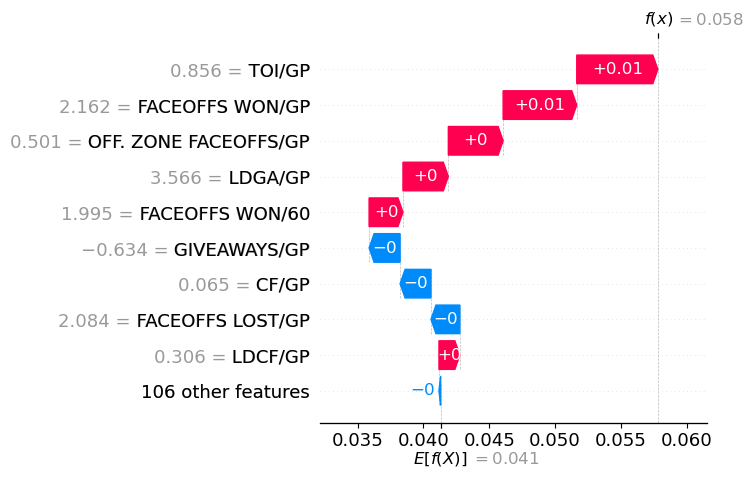

In [47]:
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=numerical_features, index=X_test.index)
explainer = shap.Explainer(pipeline.named_steps['regressor'])
shap_values = explainer(X_test_transformed_df)

fig = plt.figure()
shap.plots.waterfall(shap_values[0], show=False)
plt.gcf().set_size_inches(5,5)
plt.show()


In [21]:
shap.plots.force(shap_values[0])

In [27]:
shap.plots.force(shap_values[:100])

<Figure size 640x480 with 0 Axes>

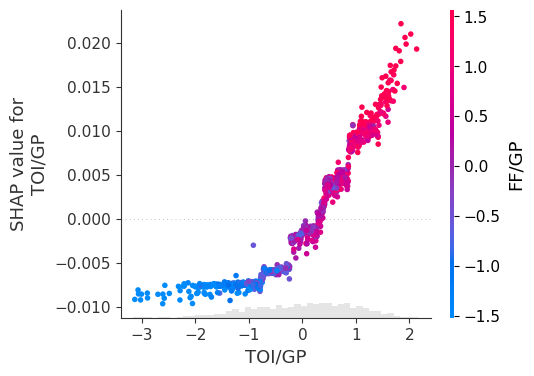

In [46]:
fig = plt.figure()
shap.plots.scatter(shap_values[:, "TOI/GP"], color=shap_values, show=False)
plt.gcf().set_size_inches(5,4)
plt.show()

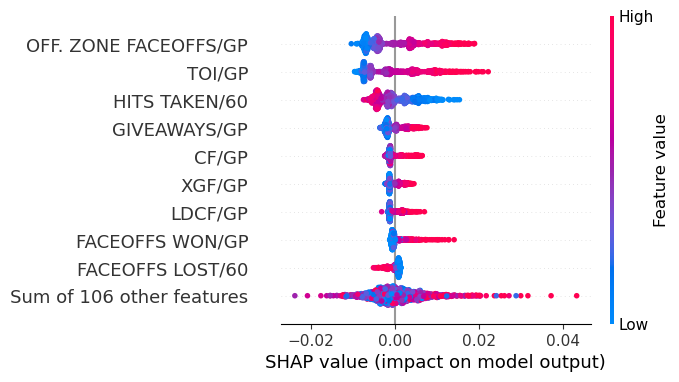

In [44]:
fig = plt.figure()
shap.plots.beeswarm(shap_values, show=False)
plt.gcf().set_size_inches(5,4)
plt.show()

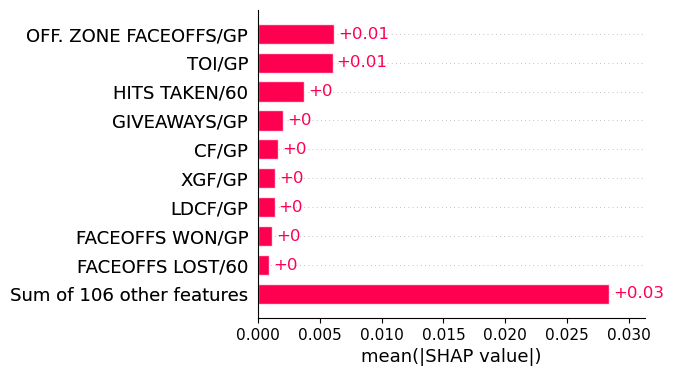

In [45]:
fig = plt.figure()
shap.plots.bar(shap_values, show=False)
plt.gcf().set_size_inches(5,4)
plt.show()
